In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os

In [ ]:
# =====================================================================
# Step 1: Define Paths (Update with your actual paths)
# =====================================================================
 # Replace with your folder path
base_dir = r'C:\Users\BAPS\Documents\Classifier_Brain_Tumour'
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Testing')

# Verify paths exist
assert os.path.exists(train_dir), f"Directory {train_dir} not found!"
assert os.path.exists(test_dir), f"Directory {test_dir} not found!"

In [ ]:
# =====================================================================
# Step 2: Load Binary Dataset (Tumor vs. No Tumor)
# =====================================================================
# Load training data
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',  # Binary labels (tumor=1, no_tumor=0)
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    color_mode='grayscale'  # Use 'rgb' if images are color
)

# Load testing data
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    image_size=(224, 224),
    batch_size=32,
    shuffle=False,
    color_mode='grayscale'
)

# =====================================================================
# =====================================================================


Found 5712 files belonging to 2 classes.
Found 1311 files belonging to 2 classes.


In [ ]:
# Step 3: Build Binary Classification Model
# =====================================================================
def build_model():
    model = models.Sequential([

        layers.Input(shape=(224, 224, 1)),  # 1 channel for grayscale
        # Preprocessing layers (resize + normalize)
        layers.Resizing(224, 224),  # Handles variable input sizes
        layers.Rescaling(1./255),   # Normalize pixels [0, 255] → [0, 1]
        
        # Feature extraction
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        
        # Classifier
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary output
    ])
    return model

model = build_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,244,353 (84.86 MB)

 Trainable params: 22,244,353 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 4: Compile and Train
# =====================================================================
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

# =====================================================================
class_weight = None  # Set based on your data distribution
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(
            filepath='brain_tumor_model.keras',  # <-- Added here
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ],
    class_weight=class_weight
)

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8255 - loss: 0.4342 - precision: 0.8410 - recall: 0.9274
Epoch 1: val_loss improved from inf to 0.23603, saving model to brain_tumor_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.8259 - loss: 0.4332 - precision: 0.8414 - recall: 0.9276 - val_accuracy: 0.8947 - val_loss: 0.2360 - val_precision: 0.8895 - val_recall: 0.9680
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9510 - loss: 0.1358 - precision: 0.9550 - recall: 0.9772
Epoch 2: val_loss improved from 0.23603 to 0.15429, saving model to brain_tumor_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.9511 - loss: 0.1357 - precision: 0.9551 - recall: 0.9772 - val_accuracy: 0.9466 - val_loss: 0.1543 - val_precision: 0.9739 - val_recall: 0.9481
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9710 - loss: 0.0882 - precision: 0.9789 - recall: 0.9805
Epoch 3: val_loss improved from 0.15429 to 0.11323, sa

In [ ]:
# Evaluate on test data
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")

# Confusion matrix
y_true = []
y_pred = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())
    y_pred.extend((model.predict(images) > 0.5).astype("int32"))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step - accuracy: 0.9984 - loss: 0.0079 - precision: 0.7143 - recall: 0.7115
Test Accuracy: 1.00
Test Precision: 1.00
Test Recall: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━

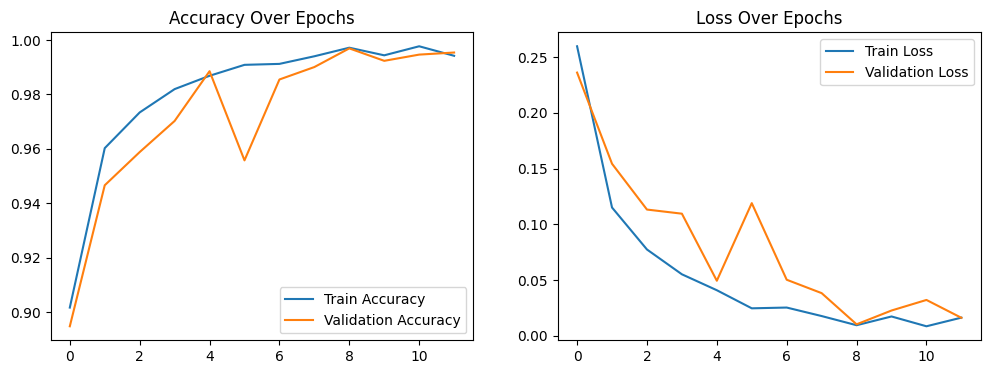

In [ ]:
import matplotlib.pyplot as plt
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.show()

In [ ]:
# Save entire model (including optimizer state)
model.save('final_brain_tumor_model.keras')

# Optional: Save training history
import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
def predict_tumor(image_path):
    # Load image (match your model's expected format)
    img = tf.keras.utils.load_img(
        image_path,
        color_mode='grayscale',  # Must match your training data format
        target_size=(224, 224)   # Must match your model's input size
    )
    
    # Convert to array and preprocess
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Make prediction
    prediction = model.predict(img_array)[0][0]
    
    return "Tumor" if prediction > 0.5 else "No Tumor"

In [ ]:
# Test your prediction function
test_image_path = "braim tumour prediction sathi.jpg"
print(predict_tumor(test_image_path))

# Get probability scores
def get_tumor_probability(image_path):
    img = tf.keras.utils.load_img(image_path, color_mode='grayscale', target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    return model.predict(img_array)[0][0]

print(f"Tumor probability: {get_tumor_probability(test_image_path):.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Tumor probability: 99.29%


In [ ]:
test_image_path = "notumourimage.jpeg"
print(f"Tumor probability: {get_tumor_probability(test_image_path):.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Tumor probability: 0.00%
